In [1]:
from src.application.services.portfolio_constructor import Portfolio_Constructor
from src.domain.services.stats.betting_statistics import BetsToEquity, drawdown, total_return, annual_return, equity_to_variations_month_year
from src.application.bots.betting_trading.get_historical_data_betting import save_historical
from src.application.bots.betting_trading.get_historical_data_betting import _get_historical_data_test_files_betfair as get_historical_data
import datetime as dt
import pandas as pd

/usr/local/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1) Download Historical Data from test data

In [2]:
download_data = False # True for downloading
if download_data:
    provider = 'betfair'
    data = get_historical_data()
    save_historical(data, name_library=f'{provider}_historical')
    print(f'* Historical data for {provider} saved')

BACKTESTING A BETTING STRATEGY

2) Backtesting

In [3]:
# SETTING

provider = 'betfair'
start_date = dt.datetime(2022,1,1) # Start date for backtesting
end_date = dt.datetime(2023, 1, 1)

strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Basic_Strategy', # strategy name, create in smartbots/betting/strategies
             'params': {'ticker': 'over/under 2.5 goals',
             'selection': 'over 2.5 goals',
             'action': 'back',
             'quantity': 2,
             'init_odd':1.5,
             'end_odd': 1.7,
             'init_time':10,
             'end_time': 30,
             'diff_odds': 0.03}}


conf_portfolio = {'Name': 'PortfolioBetting1',
                  'Data_Sources': 
                  [{'ticker': 'over/under 2.5 goals',
                   'event_type': 'odds',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_files_historical'}],
                   'Strategies': 
                    [strategy1]}

In [4]:
%%time
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type='betting',
                                  send_orders_to_broker=False, start_date=start_date, end_date=end_date)
print('Generating Backtesting....you need to wait')
portfolio.run_simulation() # backtest 
bets = portfolio.bets
result = portfolio.bets_result

Generating Backtesting....you need to wait
CPU times: user 489 ms, sys: 15.1 ms, total: 504 ms
Wall time: 527 ms


In [5]:
# BETTING STATS

bets_to_equity = BetsToEquity(bets, result, capital_init=2000, commission=0.02)
df_equity = pd.DataFrame({'equity': bets_to_equity.equity, 'datetime': bets_to_equity.datetime})
df_equity['datetime'] = df_equity['datetime'].dt.date
# convert to datetime
df_equity['datetime'] = pd.to_datetime(df_equity['datetime'])
# get daily equity
df_equity = df_equity.drop_duplicates(subset='datetime', keep='last')
# datetime to index
df_equity.index = df_equity['datetime']
# get draw down
draw = drawdown(df_equity.index, df_equity['equity'])

statistics = {}
statistics['max_draw'] = round(max(draw['draw_down']) * 100, 3)
statistics['max_draw_dur'] = max(draw['drawdowndur'])
statistics['annual_return'] = round(annual_return(df_equity['equity'], difference_prices=False), 3)
statistics['total_return'] = round(total_return(df_equity['equity']), 2)
statistics['calmar'] = round(statistics['annual_return'] / statistics['max_draw'], 3)
statistics['bets'] = bets_to_equity.success + bets_to_equity.failed
statistics['average_oods'] = bets_to_equity.sum_odds / statistics['bets']
statistics['probability_odds'] = 1 / statistics['average_oods'] * 100
statistics['reliability'] = round(bets_to_equity.success / statistics['bets'] * 100, 3)

print(statistics)


{'max_draw': 0.0, 'max_draw_dur': 0.0, 'annual_return': 11.923, 'total_return': 0.06, 'calmar': inf, 'bets': 2, 'average_oods': 1.6349999999999998, 'probability_odds': 61.16207951070337, 'reliability': 100.0}


In [6]:
# GET MONTH VARIATIONS
equity_to_variations_month_year(df_equity['equity'], _type='M')

datetime
2022-08-31    0.061741
Freq: -1M, Name: equity, dtype: float64

,equity,datetime
datetime,,
2022-08-07,2001.2544,2022-08-07
2022-08-08,2002.4900,2022-08-08


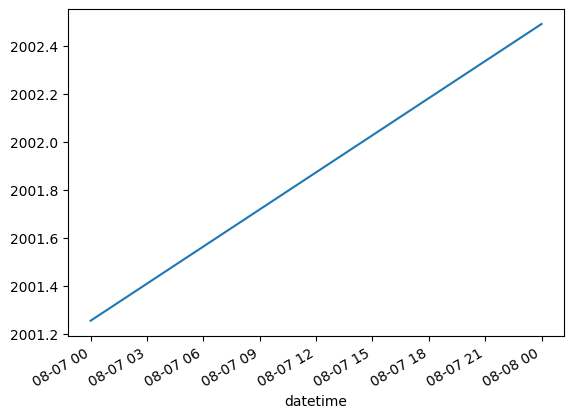

In [7]:
# VISUALIZE EQUITY
df_equity['equity'].plot()
df_equity